In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from torch import nn
import torch
from xgboost import XGBRegressor


In [3]:
# --- LSTM Feature Extractor ---
class LSTMFeatureExtractor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMFeatureExtractor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out[:, -1, :]

In [4]:
# --- 1. Load and preprocess data ---
df = pd.read_csv("../datasets/weather_aggregration/weather_combined.csv")
df['Date Time'] = pd.to_datetime(df['Date Time'], dayfirst=True)
df = df.sort_values('Date Time')
df = df.drop(columns=['source_file'])

# Fill missing values only for numeric columns
df_numeric = df.select_dtypes(include=[np.number])
df[df_numeric.columns] = df_numeric.interpolate(method='linear')
df = df.dropna()

# Standardize features
features = df.drop(columns=['Date Time'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_data, columns=features.columns, index=df['Date Time'])

In [5]:
# --- 2. Create supervised time series data ---
LOOKBACK = 96
HORIZONS = [96, 192, 336, 720]
TARGET_COL = 'T (degC)'
selected_df = scaled_df.copy()

def create_supervised_data(data, target_column, window_size, horizon):
    X, y = [], []
    target_series = data[target_column].values
    for i in range(window_size, len(data) - horizon):
        X.append(data.iloc[i - window_size:i].values)
        y.append(target_series[i:i + horizon])
    return np.array(X), np.array(y)

multi_step_data = {}
for h in HORIZONS:
    X_h, y_h = create_supervised_data(selected_df, TARGET_COL, LOOKBACK, h)
    multi_step_data[h] = {'X': X_h, 'y': y_h}
    print(f"Horizon {h} - X: {X_h.shape}, y: {y_h.shape}")

# --- Supervised data for single-step forecast ---
X_single, y_single = [], []
target_series = selected_df[TARGET_COL].values
for i in range(LOOKBACK, len(selected_df)):
    X_single.append(selected_df.iloc[i - LOOKBACK:i].values)
    y_single.append(target_series[i])
X_single = np.array(X_single)
y_single = np.array(y_single)

Horizon 96 - X: (262953, 96, 21), y: (262953, 96)
Horizon 192 - X: (262857, 96, 21), y: (262857, 192)
Horizon 336 - X: (262713, 96, 21), y: (262713, 336)
Horizon 720 - X: (262329, 96, 21), y: (262329, 720)


In [6]:
# Giới hạn số mẫu để tránh tràn bộ nhớ
MAX_SAMPLES = 10000
X_single = X_single[:MAX_SAMPLES]
y_single = y_single[:MAX_SAMPLES]

In [8]:
# --- 3. Extract features using LSTM (on CPU to reduce memory) ---
def extract_lstm_features(X, input_size):
    model = LSTMFeatureExtractor(input_size)
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        features = model(X_tensor).numpy()
    return features

# --- Extract and train for single-step ---
features_single = extract_lstm_features(X_single, input_size=X_single.shape[2])
xgb_single = XGBRegressor(n_estimators=100,max_depth =5, learning_rate=0.01, random_state=42)
xgb_single.fit(features_single, y_single)
y_pred_single = xgb_single.predict(features_single)
mse_single = mean_squared_error(y_single, y_pred_single)
mae_single = mean_absolute_error(y_single, y_pred_single)
print("\n--- Dự báo một bước ---")
print(f"MSE: {mse_single:.4f}, MAE: {mae_single:.4f}")


--- Dự báo một bước ---
MSE: 0.0394, MAE: 0.1548



--- Đánh giá dự báo đa bước ---
Horizon 96 - MSE: 0.0774, MAE: 0.2160


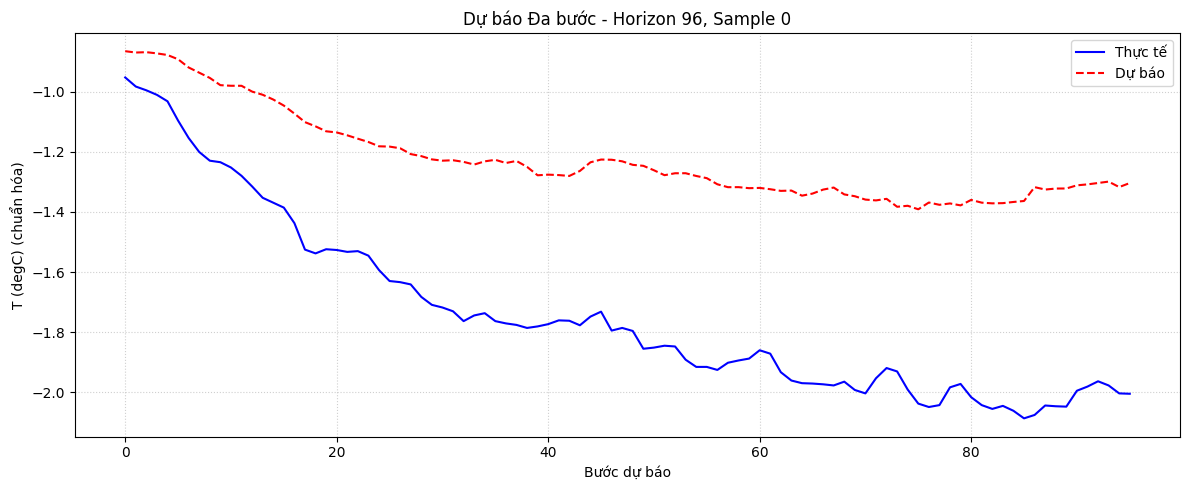

Horizon 192 - MSE: 0.0939, MAE: 0.2378


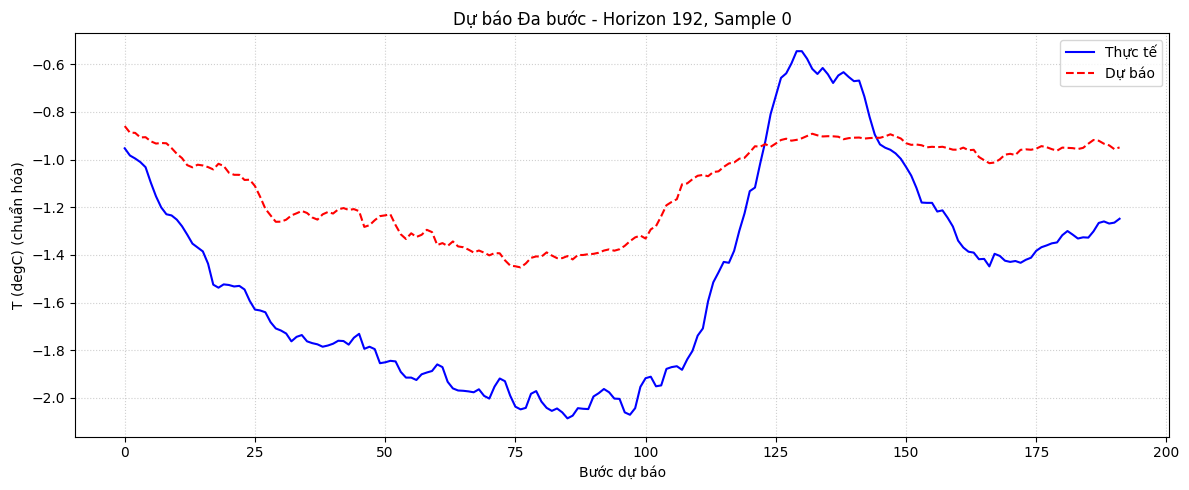

Horizon 336 - MSE: 0.1105, MAE: 0.2617


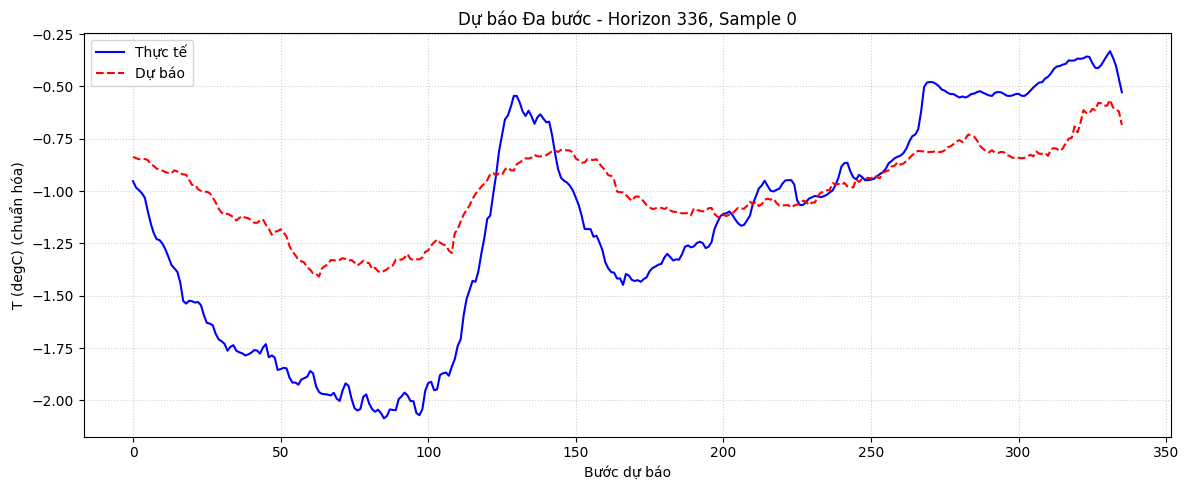

Horizon 720 - MSE: 0.1276, MAE: 0.2806


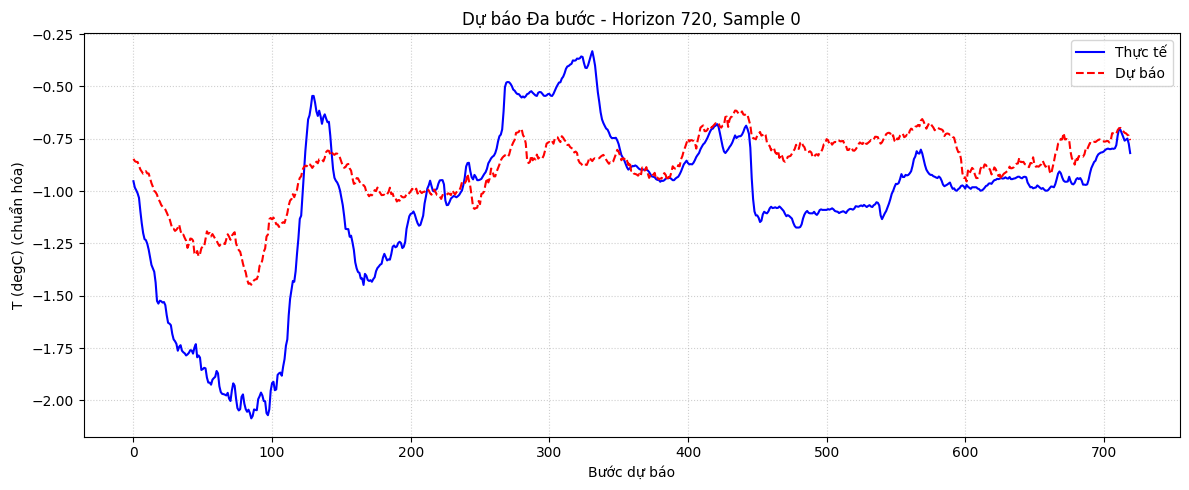


Tổng MSE: 0.4095, Tổng MAE: 0.9962


In [9]:
# --- 4. Train XGBoost and evaluate ---
def train_and_evaluate(X, y):
    model = MultiOutputRegressor(XGBRegressor(n_estimators=100, max_depth = 5, learning_rate=0.01, random_state=42))
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return model, mse, mae, y_pred

print("\n--- Đánh giá dự báo đa bước ---")
total_mse, total_mae = 0, 0

for h in HORIZONS:
    X_h = multi_step_data[h]['X']
    y_h = multi_step_data[h]['y']
    X_h = X_h[:MAX_SAMPLES]
    y_h = y_h[:MAX_SAMPLES]
    features_h = extract_lstm_features(X_h, input_size=X_h.shape[2])
    model, mse, mae, y_pred = train_and_evaluate(features_h, y_h)
    print(f"Horizon {h} - MSE: {mse:.4f}, MAE: {mae:.4f}")
    total_mse += mse
    total_mae += mae

    # Vẽ biểu đồ mẫu
    if y_h.shape[0] > 0:
        sample_idx = 0
        plt.figure(figsize=(12, 5))
        plt.plot(y_h[sample_idx], label='Thực tế', color='blue')
        plt.plot(y_pred[sample_idx], label='Dự báo', color='red', linestyle='--')
        plt.title(f'Dự báo Đa bước - Horizon {h}, Sample {sample_idx}')
        plt.xlabel('Bước dự báo')
        plt.ylabel(TARGET_COL + ' (chuẩn hóa)')
        plt.legend()
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.show()

print(f"\nTổng MSE: {total_mse:.4f}, Tổng MAE: {total_mae:.4f}")